# ch_12 Vanishing Gradient, ReLU

이전 챕터에서 여러 층으로 구성된 Multi Layer Perceptron 모델을 만들고, 분류 모델을 학습시켜 보았습니다. 여기서 궁금해집니다. 여러 층을 쌓을 수록 성능이 좋아진다면 무한히 층을 여러개 쌓으면 성능이 계속해서 좋아지지 않을까요? 한번 만들어보겠습니다.

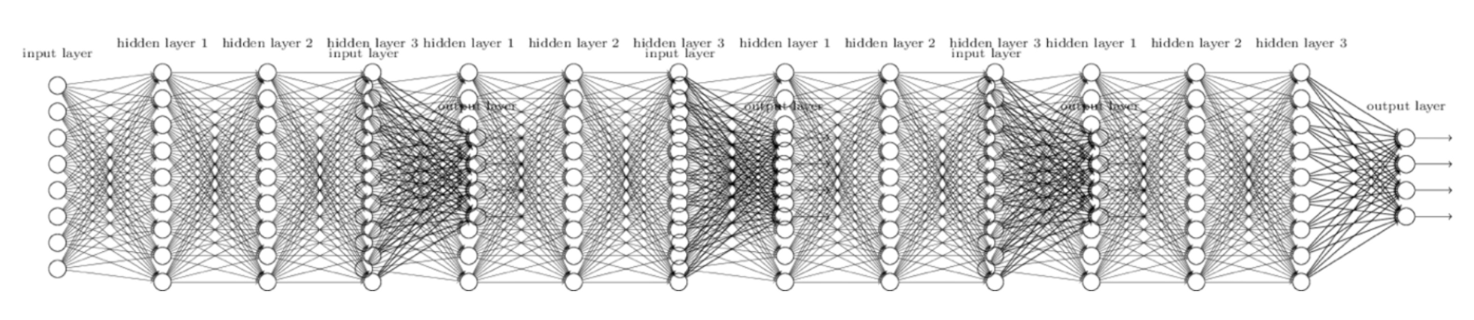

## 데이터 셋 준비

In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [2]:
train_dataset = MNIST(root="data", train=True, download=True, transform=ToTensor())
val_dataset = MNIST(root="data", train=False, download=True, transform=ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

## 깊은 신경망 모델 

### 모델 작성

총 10층으로 구성된 깊은 신경망 모델을 모델을 만들어 보겠습니다.

In [3]:
import torch

class DeepMLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepMLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc7 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc8 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc9 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc10 = torch.nn.Linear(hidden_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=1)
        self.activation = torch.nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.activation(self.fc6(x))
        x = self.activation(self.fc7(x))
        x = self.activation(self.fc8(x))
        x = self.activation(self.fc9(x))
        x = self.softmax(self.fc10(x))
        return x

In [41]:
model = DeepMLP(input_dim=(28*28), hidden_dim=50, output_dim=10)

In [42]:
from torchsummary import summary

summary(model, input_size=(28, 28, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]          39,250
           Sigmoid-2                   [-1, 50]               0
            Linear-3                   [-1, 50]           2,550
           Sigmoid-4                   [-1, 50]               0
            Linear-5                   [-1, 50]           2,550
           Sigmoid-6                   [-1, 50]               0
            Linear-7                   [-1, 50]           2,550
           Sigmoid-8                   [-1, 50]               0
            Linear-9                   [-1, 50]           2,550
          Sigmoid-10                   [-1, 50]               0
           Linear-11                   [-1, 50]           2,550
          Sigmoid-12                   [-1, 50]               0
           Linear-13                   [-1, 50]           2,550
          Sigmoid-14                   

### 하이퍼 파라미터 셋팅 

In [4]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss() 
epochs = 10

### 학습

In [5]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [10]:
from collections import defaultdict 
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = torch.argmax(outputs, dim=1)
        acc = accuracy_score(y_train, pred)
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [11]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(val_dataloader):
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())
            
            pred = torch.argmax(outputs, dim=1)
            acc = accuracy_score(y_val, pred)
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [12]:
from collections import defaultdict

def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

In [13]:
logs = train_validate_model(model)

100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 775.96it/s]


epoch 1 train - loss: 2.3017 acc: 0.111 val - loss: 2.3016 acc: 0.1135


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 804.44it/s]


epoch 2 train - loss: 2.3016 acc: 0.1121 val - loss: 2.3012 acc: 0.1135


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 813.09it/s]


epoch 3 train - loss: 2.3014 acc: 0.1117 val - loss: 2.301 acc: 0.1136


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 788.13it/s]


epoch 4 train - loss: 2.3014 acc: 0.1124 val - loss: 2.301 acc: 0.1134


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 770.41it/s]


epoch 5 train - loss: 2.279 acc: 0.1312 val - loss: 2.2087 acc: 0.2045


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 798.07it/s]


epoch 6 train - loss: 2.2088 acc: 0.2042 val - loss: 2.2092 acc: 0.2037


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 814.93it/s]


epoch 7 train - loss: 2.206 acc: 0.2073 val - loss: 2.2028 acc: 0.2088


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 807.83it/s]


epoch 8 train - loss: 2.2056 acc: 0.2088 val - loss: 2.2025 acc: 0.21


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 807.60it/s]


epoch 9 train - loss: 2.2048 acc: 0.2104 val - loss: 2.2013 acc: 0.2114


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 825.67it/s]

epoch 10 train - loss: 2.2058 acc: 0.209 val - loss: 2.2047 acc: 0.2081


In [14]:
from matplotlib import pyplot as plt

def plot_loss_acc(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

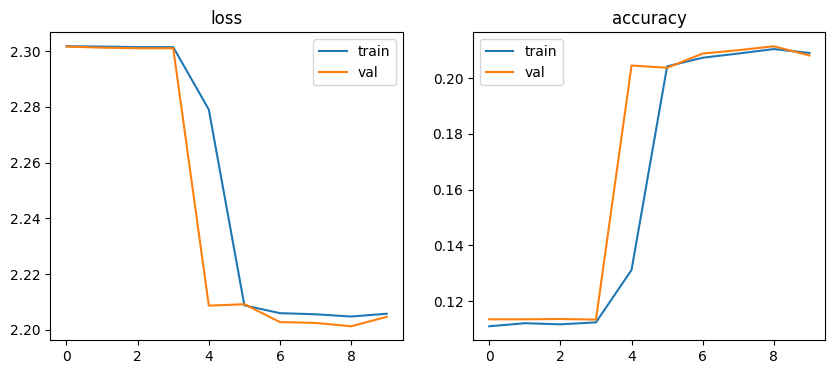

In [15]:
plot_loss_acc(logs)

## Vanishing Gradient

층을 더 깊게 쌓을 수록 오히려 모델이 학습되지 않는 현상이 발생합니다. 이는 출력 레이어로부터 멀어질 수록, 오류 역전파가 제대로 전달되지 않기 때문입니다. 이런 현상이 바로 두번째 AI winter를 불러온 vanishing gradient 현상입니다.

### Sigmoid
앞서서 뉴럴 넷 한층을 통과한 값들을 sigmoid에 통과시킨 뒤, 다음 레이어로 전달했습니다. 이 때, sigmoid 함수 때문에 vanishing gradient 현상이 발생합니다.

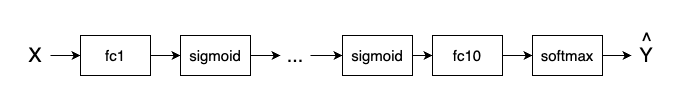

sigmoid 함수와 sigmoid 함수를 미분한 함수의 그래프를 그려보겠습니다.

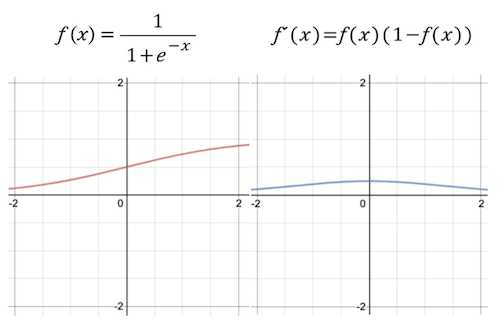

sigmoid 함수는 0과 1 사이로 출력값을 줍니다. 이를 미분한 함수는 최대 값이 0.5인 완만한 함수입니다. 즉, back propagation을 하기 위해서 각 웨이트 별로 chain rule을 통해서 편미분 값을 계산하면, sigmoid 층을 한번 통과할 때마다 편미분 값이 0.5 이하로 줄어든다는 의미입니다.

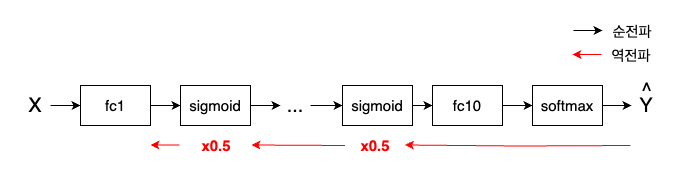

역전파를 하기 위해 앞쪽에 위치한 웨이트 값들의 편미분 값을 계산하면 sigmoid를 미분한 함수를 통과하면서 값이 점점 작아져 0에 수렴하게 됩니다. 즉, 층을 더 깊이 쌓을 수록 앞쪽에 위치한 레이어들은 학습이 이루어지지 않습니다. 이를 gradient가 점점 사라진다고 하여 vanishing gradient 라고 부릅니다.

### ReLU

그래서 등장한 것이 ReLU 함수입니다.  ReLU 함수는 입력 값이 0보다 작을 때는 0, 0보다 크면 값을 그대로 리턴해주는 함수입니다. 이를 미분한 함수는 0이하일 때는 0, 0보다 크면 1을 리턴하는 함수가 됩니다. 앞서서 깊이 쌓은 신경망 모델의 activation function을 ReLU 함수로 교체해보면 아래와 같습니다.

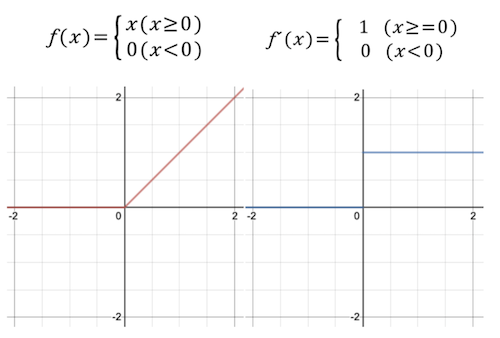

## ReLU로 교체 후 재학습

기존에 sigmoid activation function을 ReLU로 교체한 뒤, 모델을 다시 학습시켜 보겠습니다.

In [45]:
import torch

class ReluMLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ReluMLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc7 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc8 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc9 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc10 = torch.nn.Linear(hidden_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=1)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.activation(self.fc6(x))
        x = self.activation(self.fc7(x))
        x = self.activation(self.fc8(x))
        x = self.activation(self.fc9(x))
        x = self.softmax(self.fc10(x))
        return x

In [46]:
model = ReluMLP(input_dim=(28*28), hidden_dim=50, output_dim=10)

In [47]:
summary(model, input_size=(28, 28, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]          39,250
              ReLU-2                   [-1, 50]               0
            Linear-3                   [-1, 50]           2,550
              ReLU-4                   [-1, 50]               0
            Linear-5                   [-1, 50]           2,550
              ReLU-6                   [-1, 50]               0
            Linear-7                   [-1, 50]           2,550
              ReLU-8                   [-1, 50]               0
            Linear-9                   [-1, 50]           2,550
             ReLU-10                   [-1, 50]               0
           Linear-11                   [-1, 50]           2,550
             ReLU-12                   [-1, 50]               0
           Linear-13                   [-1, 50]           2,550
             ReLU-14                   

In [36]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss() 
epochs = 10

In [19]:
logs = train_validate_model(model)

100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 834.66it/s]


epoch 1 train - loss: 1.8679 acc: 0.5892 val - loss: 1.7144 acc: 0.7501


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 836.96it/s]


epoch 2 train - loss: 1.7745 acc: 0.6879 val - loss: 1.8195 acc: 0.6411


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 861.32it/s]


epoch 3 train - loss: 1.7801 acc: 0.6811 val - loss: 1.7596 acc: 0.7012


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 854.10it/s]


epoch 4 train - loss: 1.7893 acc: 0.6716 val - loss: 1.7546 acc: 0.7063


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 857.64it/s]


epoch 5 train - loss: 1.7971 acc: 0.6638 val - loss: 1.8387 acc: 0.6224


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 845.65it/s]


epoch 6 train - loss: 1.8555 acc: 0.6054 val - loss: 1.8222 acc: 0.6387


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 857.20it/s]


epoch 7 train - loss: 1.7821 acc: 0.679 val - loss: 1.7498 acc: 0.7112


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 868.31it/s]


epoch 8 train - loss: 1.8251 acc: 0.6359 val - loss: 1.8395 acc: 0.6216


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 858.73it/s]


epoch 9 train - loss: 1.8069 acc: 0.6541 val - loss: 1.8485 acc: 0.6125


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 851.99it/s]

epoch 10 train - loss: 1.8581 acc: 0.6028 val - loss: 1.8218 acc: 0.6393


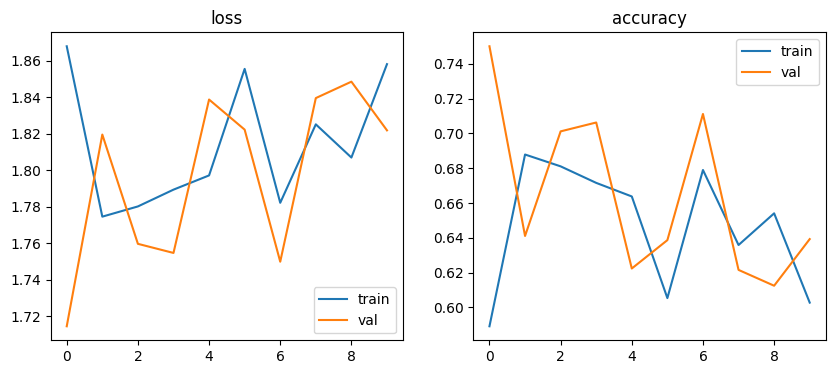

In [20]:
plot_loss_acc(logs)

전혀 학습이 이루어지지 않던 상태에서 어느 정도 학습이 진행되었습니다. 바로 ReLU activation을 사용해서 Vanishing Gradient 현상을 완화 시켜준 것입니다. 

### 그 밖에 vanishing gradient 극복 방안

그럼에도 불구하고  신경망의 층이 깊어지면 vanishing gradient 현상으로 학습이 어려워집니다. ReLU 활성화 함수 이외에도 vanishing gradient 문제를 해결하기 위해 많은 기법들이 제안되었습니다.

- weight initialization: 처음 모델을 생성할 때, 웨이트 값 초기화를 잘해서 vanishng gradient를 방지하자는 기법입니다. He initailization이나 Xavier initialization 등이 있습니다.
    - 자세한 내용: https://yeomko.tistory.com/40
- Batch Normalization: 배치 내에서 데이터를 평균과 분산으로 정규화 하는 기법입니다. 이를 통해 Gradient 전파를 돕고, 학습을 안정화 시킵니다.

- Residual Connection: 잔차 연결은 각 계층의 출력을 활성화 함수를 거치지 않고 바로 다음 계층으로 전달하는 구조입니다. 이를 통해 그래디언트가 원본 입력까지 빠르게 전달되어 vanishing gradient 문제를 완화할 수 있습니다. (ResNet의 핵심 아이디어, ResNet는 CS 역사상 가장 많은 citation을 받는 paper)

- Gradient Clilpping: 그래디언트의 크기를 임계값 이하로 제한하여 폭주하는 그래디언트를 방지할 수 있습니다.

- 다양한 아키텍처: 모델 아키텍처 단에서 vanishing gradient 문제를 완화시키는 방안도 고안되었습니다. InceptionNet 등이 대표적인 사례입니다.

## 정리

이번 챕터에서는 딥러닝 모델 학습이 어려웠던 원인 중 하나인 vanishing gradient에 대해서 알아보았습니다. 그리고 ReLU 활성화 함수를 사용하여 어느정도 극복해보았습니다. Vanishing Gradient 현상의 원인과 극복 방안은 딥러닝 관련 면접 단골 질문들이니 잘 기억해주시기 바랍니다.